In [3]:
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import os
os.chdir('/Users/jhou2/Documents/GitHub/PertussisVaccine_Prediction/')

In [113]:
# Load data
Ab_titer_df = pd.read_csv('data/output/Ab_titer.csv')
RNAseq_df = pd.read_csv('data/output/RNAseq.csv')
Cell_Freq_df = pd.read_csv('data/output/Cell_Freq.csv')

In [114]:
# Feature engineering: remove non-specific features
remove_features_ab = Ab_titer_df.columns.str.contains('TT|DT|OVA')
Ab_titer_df = Ab_titer_df.loc[:, ~remove_features_ab]

remove_features_cellfreq = Cell_Freq_df.columns.str.contains('CD3CD19neg|CD3.Tcells|B.cells..CD19.CD3.CD14.CD56..|B.cells..CD19.CD20.CD3.CD14.CD56..|CD56.CD3.T.cells|CD4.CD8..T.cells|CD4.CD8..T.cells.1|NK.cells..CD3.CD19.CD56..|CD3.CD19.CD56..cells|non.pDCs|CD3.CD19.CD56.CD14.CD16.CD123.CD11c.HLA.DR.cells|Lineage.negative.cells..CD3.CD19.CD56.HLA.DR.CD123.CD66b..')
Cell_Freq_df = Cell_Freq_df.loc[:, ~remove_features_cellfreq]

In [ ]:
# remove 2023 dataset as it missing target variable
Ab_titer_df = Ab_titer_df[Ab_titer_df['dataset'] != '2023_dataset']
RNAseq_df = RNAseq_df[RNAseq_df['dataset'] != '2023_dataset']
Cell_freq_df = Cell_Freq_df[Cell_Freq_df['dataset'] != '2023_dataset']

In [ ]:
Ab_titer_df.shape, RNAseq_df.shape, Cell_freq_df.shape

((705, 29), (507, 6613), (403, 37))

In [ ]:
# merge all dataframes on 'sample_id'
# .drop(columns=['subject_id', 'timepoint', 'dataset', 'date_of_boost', 'race', 'age_at_boost'])
all_data_df = pd.merge(Ab_titer_df, 
                       RNAseq_df, 
                       on='specimen_id', how='outer')

all_data_df = pd.merge(all_data_df,
                       Cell_freq_df.drop(columns=['subject_id', 'timepoint', 'dataset', 'date_of_boost', 'race', 'age_at_boost']), 
                       on='specimen_id', how='outer')

In [ ]:
temp = all_data_df[all_data_df['timepoint'] == 0]

In [129]:
temp['age']

0       NaN
3       NaN
9       NaN
14    27.00
20      NaN
       ... 
669   19.00
678   21.00
687   27.00
695   24.00
701     NaN
Name: age, Length: 112, dtype: float64

In [ ]:
# Prepare Ab single modulaity data
Ab_titer_day0 = Ab_titer_df[Ab_titer_df['timepoint']== 0]
Ab_titer_day14 = Ab_titer_df[Ab_titer_df['timepoint']== 14].rename(columns={'IgG_PT': 'IgG_PT_day14'})

In [35]:
Ab_titer_day0.shape, Ab_titer_day14.shape

((112, 29), (111, 29))

In [ ]:
# split into train and test datasets
# Ab_day0_train = Ab_titer_day0[Ab_titer_day0['dataset'] == "2023_dataset"]
# Ab_day0_test = Ab_titer_day0[Ab_titer_day0['dataset'] != "2023_dataset"]

In [45]:
# Combine Ab features data (day 0) with target (day 14) by merging on 'subject_id'
# innter join to ensure only subjects present in both datasets are included
print(f"Rows before merge: {len(Ab_titer_day0)}")
Ab_titer = pd.merge(Ab_titer_day0, Ab_titer_day14[['IgG_PT_day14', 'subject_id']], on='subject_id', how='inner')


Rows before merge: 112


In [37]:
print(f"Rows after merge: {len(Ab_titer)}")

Rows after merge: 111


In [46]:
# Drop unnecessary columns # 
Ab_titer = Ab_titer.drop(columns=['specimen_id', 'subject_id', 'timepoint', 'dataset', 'date_of_boost', 'race', 'age_at_boost'])
Ab_titer

,IgG_PT,IgG_PRN,IgG_FHA,IgG1_PT,IgG1_PRN,IgG1_FHA,IgG1_FIM2.3,IgG2_PT,IgG2_PRN,IgG2_FHA,...,IgG3_FHA,IgG3_FIM2.3,IgG4_PT,IgG4_PRN,IgG4_FHA,IgG4_FIM2.3,infancy_vac,biological_sex,age,IgG_PT_day14
0,2.98,2.01,26.64,10.10,2.04,4.62,0.16,2.41,1.33,2.23,...,0.47,-17.27,-3.68,9.72,0.70,0.64,wP,Female,30,10.09
1,1.23,1.10,1.74,1.90,1.33,1.11,-1.47,2.41,2.56,1.39,...,1.03,-17.27,-3.73,0.71,1.35,0.64,aP,Male,19,2.52
2,0.95,1.98,1.43,-1.65,1.94,0.31,1.45,2.41,-2.82,-0.21,...,0.47,-17.27,-3.49,0.47,0.22,4.30,wP,Male,23,11.83
3,0.20,1.01,1.82,-5.02,-0.00,0.83,-1.61,2.41,57.18,-0.49,...,0.58,-17.27,-3.73,0.43,0.09,0.64,wP,Male,27,4.39
4,2.28,0.60,2.69,4.19,1.36,3.64,-1.34,2.41,-3.57,-0.71,...,1.54,-15.38,-3.73,0.43,0.04,0.64,wP,Female,29,4.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,6.05,-1.90,2.34,9.86,3.01,1.56,5.91,-1.73,0.49,4.68,...,9.96,753.72,39.89,26.50,1.63,13.16,aP,Female,19,1.22
107,5.72,0.79,0.55,7.33,1.49,1.56,3.99,22.80,3.45,2.84,...,-0.88,38.05,80.09,-2.05,21.34,7.90,aP,Male,21,7.34
108,2.03,4.08,8.25,9.37,2.39,5.49,3.33,-2.65,0.15,0.48,...,-3.19,14.85,28.04,-3.80,5.17,7.72,aP,Female,27,4.01
109,1.58,-3.37,-4.09,5.76,-0.32,-1.45,-1.74,-2.56,0.04,0.93,...,-0.78,38.27,17.00,1.25,-0.93,5.53,aP,Male,24,3.41


In [47]:
Ab_titer['IgG_PT_ratio'] = Ab_titer['IgG_PT_day14'] / Ab_titer['IgG_PT']

In [82]:
# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = Ab_titer.select_dtypes(include=['object']).columns.tolist() # should be ['infancy_vac', 'biological_sex']
one_hot_encoded = encoder.fit_transform(Ab_titer[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
# Concatenate one-hot encoded features with the original DataFrame
Ab_titer_encoded = pd.concat([Ab_titer, one_hot_df], axis=1)
Ab_titer_encoded = Ab_titer_encoded.drop(categorical_columns, axis=1)

In [83]:
Ab_titer_encoded

,IgG_PT,IgG_PRN,IgG_FHA,IgG1_PT,IgG1_PRN,IgG1_FHA,IgG1_FIM2.3,IgG2_PT,IgG2_PRN,IgG2_FHA,...,IgG4_PRN,IgG4_FHA,IgG4_FIM2.3,age,IgG_PT_day14,IgG_PT_ratio,infancy_vac_aP,infancy_vac_wP,biological_sex_Female,biological_sex_Male
0,2.98,2.01,26.64,10.10,2.04,4.62,0.16,2.41,1.33,2.23,...,9.72,0.70,0.64,30,10.09,3.39,0.00,1.00,1.00,0.00
1,1.23,1.10,1.74,1.90,1.33,1.11,-1.47,2.41,2.56,1.39,...,0.71,1.35,0.64,19,2.52,2.04,1.00,0.00,0.00,1.00
2,0.95,1.98,1.43,-1.65,1.94,0.31,1.45,2.41,-2.82,-0.21,...,0.47,0.22,4.30,23,11.83,12.51,0.00,1.00,0.00,1.00
3,0.20,1.01,1.82,-5.02,-0.00,0.83,-1.61,2.41,57.18,-0.49,...,0.43,0.09,0.64,27,4.39,22.30,0.00,1.00,0.00,1.00
4,2.28,0.60,2.69,4.19,1.36,3.64,-1.34,2.41,-3.57,-0.71,...,0.43,0.04,0.64,29,4.34,1.91,0.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,6.05,-1.90,2.34,9.86,3.01,1.56,5.91,-1.73,0.49,4.68,...,26.50,1.63,13.16,19,1.22,0.20,1.00,0.00,1.00,0.00
107,5.72,0.79,0.55,7.33,1.49,1.56,3.99,22.80,3.45,2.84,...,-2.05,21.34,7.90,21,7.34,1.28,1.00,0.00,0.00,1.00
108,2.03,4.08,8.25,9.37,2.39,5.49,3.33,-2.65,0.15,0.48,...,-3.80,5.17,7.72,27,4.01,1.98,1.00,0.00,1.00,0.00
109,1.58,-3.37,-4.09,5.76,-0.32,-1.45,-1.74,-2.56,0.04,0.93,...,1.25,-0.93,5.53,24,3.41,2.16,1.00,0.00,0.00,1.00


In [50]:
# Scale numerical features
# Remove infacny_vac_aP and infacny_vac_pP from numerical columns
numerical_columns = Ab_titer_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_to_remove = ['infancy_vac_aP', 'infancy_vac_wP', 'biological_sex_Female', 'biological_sex_Male', 'IgG_PT_day14', 'IgG_PT_ratio']
numerical_columns = [col for col in numerical_columns if col not in columns_to_remove]
scaler = StandardScaler()
Ab_titer_encoded[numerical_columns] = scaler.fit_transform(Ab_titer_encoded[numerical_columns])
Ab_titer_encoded

,IgG_PT,IgG_PRN,IgG_FHA,IgG1_PT,IgG1_PRN,IgG1_FHA,IgG1_FIM2.3,IgG2_PT,IgG2_PRN,IgG2_FHA,...,IgG4_PRN,IgG4_FHA,IgG4_FIM2.3,age,IgG_PT_day14,IgG_PT_ratio,infancy_vac_aP,infancy_vac_wP,biological_sex_Female,biological_sex_Male
0,0.60,0.55,5.65,1.21,1.12,2.55,-0.38,-0.20,-0.21,-0.07,...,-0.02,-0.48,-0.19,0.81,10.09,3.39,0.00,1.00,1.00,0.00
1,-0.14,0.16,-0.02,0.06,0.32,0.13,-0.88,-0.20,-0.16,-0.22,...,-0.41,-0.39,-0.19,-0.98,2.52,2.04,1.00,0.00,0.00,1.00
2,-0.26,0.54,-0.09,-0.43,1.00,-0.42,0.02,-0.20,-0.40,-0.50,...,-0.42,-0.54,-0.10,-0.33,11.83,12.51,0.00,1.00,0.00,1.00
3,-0.58,0.12,-0.00,-0.91,-1.15,-0.06,-0.93,-0.20,2.37,-0.55,...,-0.42,-0.55,-0.19,0.32,4.39,22.30,0.00,1.00,0.00,1.00
4,0.30,-0.05,0.20,0.38,0.36,1.88,-0.84,-0.20,-0.44,-0.59,...,-0.42,-0.56,-0.19,0.65,4.34,1.91,0.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.89,-1.12,0.12,1.17,2.18,0.44,1.40,-0.61,-0.25,0.37,...,0.71,-0.36,0.13,-0.98,1.22,0.20,1.00,0.00,1.00,0.00
107,1.75,0.03,-0.29,0.82,0.50,0.44,0.81,1.82,-0.11,0.04,...,-0.53,2.14,-0.01,-0.66,7.34,1.28,1.00,0.00,0.00,1.00
108,0.20,1.43,1.46,1.10,1.50,3.15,0.60,-0.70,-0.27,-0.38,...,-0.61,0.09,-0.01,0.32,4.01,1.98,1.00,0.00,1.00,0.00
109,0.01,-1.75,-1.35,0.60,-1.51,-1.63,-0.96,-0.69,-0.27,-0.30,...,-0.39,-0.68,-0.07,-0.17,3.41,2.16,1.00,0.00,0.00,1.00


In [84]:
Ab_train_x = Ab_titer_encoded.drop(columns=['IgG_PT_day14','IgG_PT_ratio'])
Ab_train_y = Ab_titer_encoded['IgG_PT_ratio']

In [98]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(Ab_train_x, Ab_train_y, test_size=0.3, random_state=42)


In [99]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((77, 24), (34, 24), (77,), (34,))

In [74]:
import numpy as np
y_train = np.log1p(y_train)  # Log(x+1) for zeros
y_test = np.log1p(y_test)  # Log(x+1) for zeros

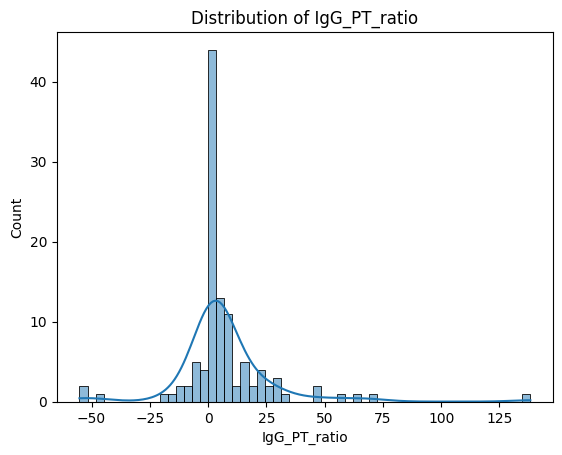

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(Ab_titer_encoded['IgG_PT_ratio'], kde=True)
plt.title("Distribution of IgG_PT_ratio")
plt.show()

In [100]:
from lazypredict.Supervised import LazyRegressor

# LazyClassifier
clf = LazyRegressor(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 24
[LightGBM] [Info] Start training from score 7.448441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [101]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KNeighborsRegressor,-1.42,0.34,11.07,0.00
RandomForestRegressor,-1.53,0.31,11.33,0.08
XGBRegressor,-2.02,0.18,12.39,0.14
GradientBoostingRegressor,-2.10,0.16,12.54,0.06
ExtraTreesRegressor,-2.25,0.11,12.85,0.04
AdaBoostRegressor,-2.34,0.09,13.01,0.05
BaggingRegressor,-2.40,0.07,13.12,0.05
LassoLarsIC,-2.52,0.04,13.36,0.00
LassoCV,-2.53,0.04,13.38,0.04


In [61]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from joblib import dump, load
import pickle

# GLM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import family
from statsmodels.stats.multitest import multipletests
 
# Modelling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, StackingRegressor, StackingClassifier
from xgboost import XGBRegressor, XGBClassifier
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from mlxtend.regressor import StackingCVRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# Mertrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, precision_score, roc_curve, recall_score, precision_recall_curve, precision_recall_fscore_support, roc_auc_score, ConfusionMatrixDisplay, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, mean_squared_error


In [102]:
n_iter = 100

rf_reg_params = {'n_estimators': Integer(100, 1000),
                   'max_depth':Integer(1, 100),
                   'min_samples_split':Integer(2, 30)}

# Use negative RMSE as the scoring metric
neg_rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

rf_reg_grid = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
                              search_spaces=rf_reg_params,
                              n_iter=n_iter,
                              cv=5,
                              n_jobs=-1,
                              scoring=neg_rmse,
                              random_state=123)

rf_reg_grid.fit(X_train, y_train)

print("Best Random Forest Classifier Parameters:", rf_reg_grid.best_params_)

/Users/jhou2/Documents/GitHub/PertussisVaccine_Prediction/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jhou2/Documents/GitHub/PertussisVaccine_Prediction/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jhou2/Documents/GitHub/PertussisVaccine_Prediction/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jhou2/Documents/GitHub/PertussisVaccine_Prediction/.ve

Best Random Forest Classifier Parameters: OrderedDict([('max_depth', 96), ('min_samples_split', 3), ('n_estimators', 100)])


In [103]:
best_rf = rf_reg_grid.best_estimator_
y_pred = best_rf.predict(X_test)

In [104]:
from sklearn.metrics import r2_score, root_mean_squared_error

# R-squared
r2 = r2_score(y_test, y_pred)

# Adjusted R-squared
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# RMSE
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R-squared: 0.3192
Adjusted R-squared: -1.4964
RMSE: 11.2520


In [105]:
from sklearn.model_selection import cross_val_score

# Cross-validated R² (more reliable)
cv_r2 = cross_val_score(best_rf, X_train, y_train, scoring='r2', cv=5).mean()
print("Cross-validated R²:", round(cv_r2, 4))

Cross-validated R²: -0.0416


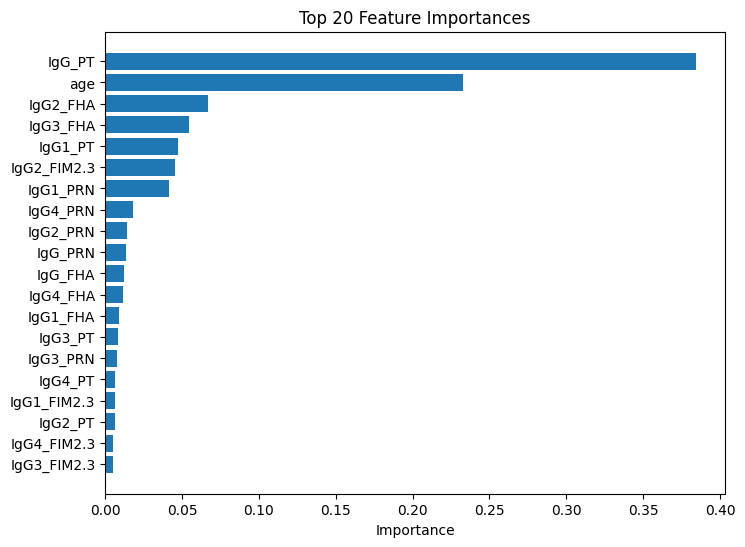

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
feat_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()